In [1]:
from __future__ import print_function, division

from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm


import copy
import os
import sys
import time

In [2]:
writer = SummaryWriter(log_dir='runs_efficientnet_b7')

In [3]:
data_dir = './data'
batch_size = 16
epoch = 50
start_epoch = 0
input_size = 224

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

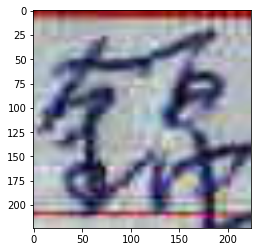

Label: 錦


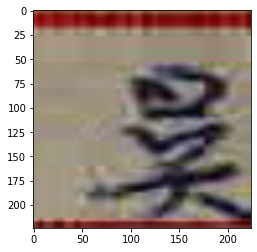

Label: 吳


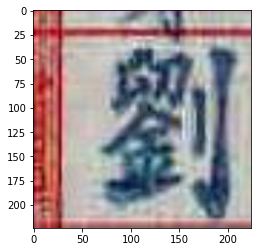

Label: 劉


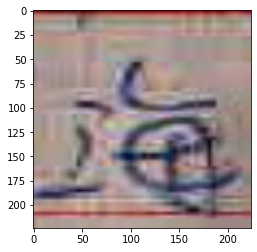

Label: 海


In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

for i in range(4):
    imshow(inputs[i])
    print(f'Label: {class_names[classes[i]]}')

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            time_elapsed = time.time() - since
            print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f}')
            
            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc
                
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60: .0f}m {time_elapsed % 60: .0f}s')
    print(f'Best val Acc: {best_acc: 4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    writer.close()
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                print(f'Label: {class_names[labels[j]]} Predict: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = EfficientNet.from_pretrained('efficientnet-b7')
num_ftrs = model_ft._fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft._fc  = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by cosine function, the first cycle is 5 epoches and the epoches of cycle will increase by multiply 2 after each cycle.
exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer_ft, T_0=5, T_mult=2)

Loaded pretrained weights for efficientnet-b7


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epoch)

  0%|          | 0/3441 [00:00<?, ?it/s]

Epoch 1/50
----------


  0%|          | 1/860 [00:00<02:43,  5.26it/s]

train Loss:  6.6323 Acc:  0.0050


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  6.4789 Acc:  0.0187

Epoch 2/50
----------


  0%|          | 1/860 [00:00<02:42,  5.30it/s]

train Loss:  5.9853 Acc:  0.0407


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  5.2967 Acc:  0.1177

Epoch 3/50
----------


  0%|          | 1/860 [00:00<02:44,  5.22it/s]

train Loss:  4.7745 Acc:  0.1751


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  4.0614 Acc:  0.3242

Epoch 4/50
----------


  0%|          | 1/860 [00:00<02:49,  5.05it/s]

train Loss:  3.8823 Acc:  0.3276


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  3.4268 Acc:  0.4548

Epoch 5/50
----------


  0%|          | 1/860 [00:00<02:39,  5.37it/s]

train Loss:  3.4878 Acc:  0.4067


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  3.2579 Acc:  0.4884

Epoch 6/50
----------


  0%|          | 1/860 [00:00<02:40,  5.34it/s]

train Loss:  2.8068 Acc:  0.5120


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  1.9300 Acc:  0.6924

Epoch 7/50
----------


  0%|          | 1/860 [00:00<02:40,  5.36it/s]

train Loss:  1.8339 Acc:  0.6916


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  1.3079 Acc:  0.7907

Epoch 8/50
----------


  0%|          | 1/860 [00:00<02:43,  5.25it/s]

train Loss:  1.3387 Acc:  0.7826


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  1.0665 Acc:  0.8321

Epoch 9/50
----------


  0%|          | 1/860 [00:00<02:43,  5.26it/s]

train Loss:  1.0710 Acc:  0.8299


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.9556 Acc:  0.8509

Epoch 10/50
----------


  0%|          | 1/860 [00:00<02:40,  5.34it/s]

train Loss:  0.9106 Acc:  0.8583


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8993 Acc:  0.8576

Epoch 11/50
----------


  0%|          | 1/860 [00:00<02:39,  5.40it/s]

train Loss:  0.8054 Acc:  0.8760


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8608 Acc:  0.8639

Epoch 12/50
----------


  0%|          | 1/860 [00:00<02:44,  5.23it/s]

train Loss:  0.7350 Acc:  0.8862


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8450 Acc:  0.8679

Epoch 13/50
----------


  0%|          | 1/860 [00:00<02:46,  5.17it/s]

train Loss:  0.6890 Acc:  0.8953


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8346 Acc:  0.8697

Epoch 14/50
----------


  0%|          | 1/860 [00:00<02:43,  5.27it/s]

train Loss:  0.6621 Acc:  0.8981


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8273 Acc:  0.8714

Epoch 15/50
----------


  0%|          | 1/860 [00:00<02:41,  5.32it/s]

train Loss:  0.6474 Acc:  0.9014


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8288 Acc:  0.8709

Epoch 16/50
----------


  0%|          | 1/860 [00:00<02:41,  5.31it/s]

train Loss:  0.6633 Acc:  0.8964


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8171 Acc:  0.8713

Epoch 17/50
----------


  0%|          | 1/860 [00:00<02:44,  5.23it/s]

train Loss:  0.5754 Acc:  0.9096


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8005 Acc:  0.8752

Epoch 18/50
----------


  0%|          | 1/860 [00:00<02:43,  5.26it/s]

train Loss:  0.4899 Acc:  0.9221


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.7911 Acc:  0.8755

Epoch 19/50
----------


  0%|          | 1/860 [00:00<02:42,  5.27it/s]

train Loss:  0.4203 Acc:  0.9313


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.7829 Acc:  0.8782

Epoch 20/50
----------


  0%|          | 1/860 [00:00<02:46,  5.17it/s]

train Loss:  0.3600 Acc:  0.9408


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.7907 Acc:  0.8775

Epoch 21/50
----------


  0%|          | 1/860 [00:00<02:43,  5.24it/s]

train Loss:  0.3069 Acc:  0.9491


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.7948 Acc:  0.8781

Epoch 22/50
----------


  0%|          | 1/860 [00:00<02:42,  5.27it/s]

train Loss:  0.2639 Acc:  0.9562


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.7928 Acc:  0.8789

Epoch 23/50
----------


  0%|          | 1/860 [00:00<02:45,  5.21it/s]

train Loss:  0.2255 Acc:  0.9632


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8011 Acc:  0.8793

Epoch 24/50
----------


  0%|          | 1/860 [00:00<02:42,  5.30it/s]

train Loss:  0.1933 Acc:  0.9691


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8141 Acc:  0.8778

Epoch 25/50
----------


  0%|          | 1/860 [00:00<02:43,  5.27it/s]

train Loss:  0.1679 Acc:  0.9735


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8140 Acc:  0.8800

Epoch 26/50
----------


  0%|          | 1/860 [00:00<02:39,  5.39it/s]

train Loss:  0.1489 Acc:  0.9773


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8189 Acc:  0.8805

Epoch 27/50
----------


  0%|          | 1/860 [00:00<02:42,  5.28it/s]

train Loss:  0.1340 Acc:  0.9805


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8234 Acc:  0.8800

Epoch 28/50
----------


  0%|          | 1/860 [00:00<02:39,  5.38it/s]

train Loss:  0.1196 Acc:  0.9828


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8249 Acc:  0.8806

Epoch 29/50
----------


  0%|          | 1/860 [00:00<02:42,  5.28it/s]

train Loss:  0.1121 Acc:  0.9845


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8286 Acc:  0.8800

Epoch 30/50
----------


  0%|          | 1/860 [00:00<02:45,  5.19it/s]

train Loss:  0.1043 Acc:  0.9859


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8275 Acc:  0.8812

Epoch 31/50
----------


  0%|          | 1/860 [00:00<02:44,  5.22it/s]

train Loss:  0.0985 Acc:  0.9873


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8321 Acc:  0.8810

Epoch 32/50
----------


  0%|          | 1/860 [00:00<02:43,  5.26it/s]

train Loss:  0.0960 Acc:  0.9879


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8303 Acc:  0.8813

Epoch 33/50
----------


  0%|          | 1/860 [00:00<02:42,  5.29it/s]

train Loss:  0.0935 Acc:  0.9877


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8291 Acc:  0.8810

Epoch 34/50
----------


  0%|          | 1/860 [00:00<02:43,  5.24it/s]

train Loss:  0.0914 Acc:  0.9888


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8299 Acc:  0.8813

Epoch 35/50
----------


  0%|          | 1/860 [00:00<02:44,  5.23it/s]

train Loss:  0.0925 Acc:  0.9877


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8315 Acc:  0.8818

Epoch 36/50
----------


  0%|          | 1/860 [00:00<02:41,  5.32it/s]

train Loss:  0.1036 Acc:  0.9847


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8485 Acc:  0.8774

Epoch 37/50
----------


  0%|          | 1/860 [00:00<02:40,  5.36it/s]

train Loss:  0.0936 Acc:  0.9868


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8552 Acc:  0.8798

Epoch 38/50
----------


  0%|          | 1/860 [00:00<02:43,  5.24it/s]

train Loss:  0.0795 Acc:  0.9894


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8535 Acc:  0.8787

Epoch 39/50
----------


  0%|          | 1/860 [00:00<02:41,  5.31it/s]

train Loss:  0.0676 Acc:  0.9915


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8657 Acc:  0.8795

Epoch 40/50
----------


  0%|          | 1/860 [00:00<02:49,  5.06it/s]

train Loss:  0.0598 Acc:  0.9926


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8606 Acc:  0.8807

Epoch 41/50
----------


  0%|          | 1/860 [00:00<02:40,  5.35it/s]

train Loss:  0.0522 Acc:  0.9939


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8787 Acc:  0.8808

Epoch 42/50
----------


  0%|          | 1/860 [00:00<02:40,  5.34it/s]

train Loss:  0.0461 Acc:  0.9951


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8807 Acc:  0.8804

Epoch 43/50
----------


  0%|          | 1/860 [00:00<02:44,  5.22it/s]

train Loss:  0.0417 Acc:  0.9957


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8821 Acc:  0.8817

Epoch 44/50
----------


  0%|          | 1/860 [00:00<02:42,  5.27it/s]

train Loss:  0.0379 Acc:  0.9961


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8845 Acc:  0.8808

Epoch 45/50
----------


  0%|          | 1/860 [00:00<02:39,  5.39it/s]

train Loss:  0.0338 Acc:  0.9966


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8866 Acc:  0.8822

Epoch 46/50
----------


  0%|          | 1/860 [00:00<02:43,  5.26it/s]

train Loss:  0.0309 Acc:  0.9966


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.8973 Acc:  0.8819

Epoch 47/50
----------


  0%|          | 1/860 [00:00<02:40,  5.34it/s]

train Loss:  0.0283 Acc:  0.9977


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.9048 Acc:  0.8819

Epoch 48/50
----------


  0%|          | 1/860 [00:00<02:40,  5.34it/s]

train Loss:  0.0261 Acc:  0.9979


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.9006 Acc:  0.8842

Epoch 49/50
----------


  0%|          | 1/860 [00:00<02:39,  5.39it/s]

train Loss:  0.0241 Acc:  0.9979


  0%|          | 0/3441 [00:00<?, ?it/s]

val Loss:  0.9089 Acc:  0.8838

Epoch 50/50
----------


  0%|          | 1/860 [00:00<02:41,  5.31it/s]

train Loss:  0.0227 Acc:  0.9981


100%|██████████| 860/860 [02:48<00:00,  5.10it/s]


val Loss:  0.8991 Acc:  0.8842

Training complete in  1901m  54s
Best val Acc:  0.884230


Label: 會 Predict: 會


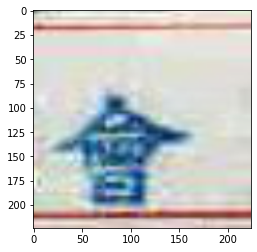

Label: 森 Predict: 森


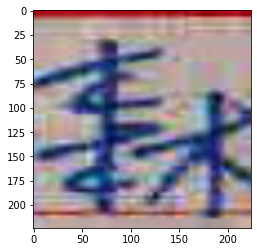

Label: 何 Predict: 何


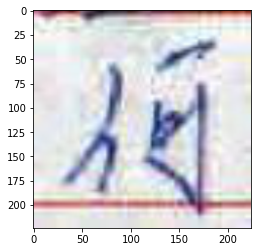

Label: 周 Predict: 周


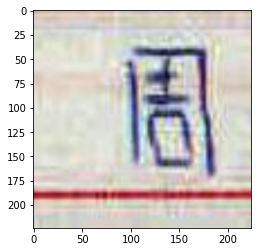

Label: 彩 Predict: 彩


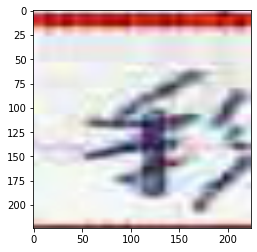

Label: 呂 Predict: 呂


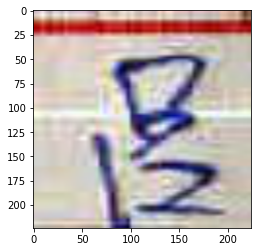

In [10]:
visualize_model(model_ft)

In [11]:
from PIL import Image

def inference_model(model, input_image_path):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        with Image.open(input_image_path) as input_image:
            resized_image = data_transforms['val'](input_image).unsqueeze(0).to(device)
            label = input_image_path.split('_')[-1].split('.')[0]
            
            output = model(resized_image)
            _, pred = torch.max(output, 1)
            
        model.train(mode=was_training)
    
    return class_names[pred[0]], label

Image 1
Predict: 田, Label: 田, Time elapsed: 0.0628519058227539



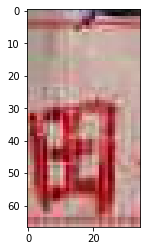

Image 2
Predict: 揚, Label: 千, Time elapsed: 0.04456758499145508



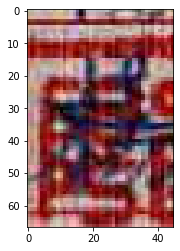

Image 3
Predict: 所, Label: 田, Time elapsed: 0.04443836212158203



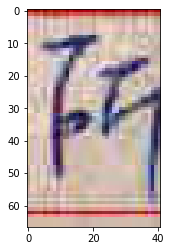

Image 4
Predict: 吳, Label: 昇, Time elapsed: 0.04452848434448242



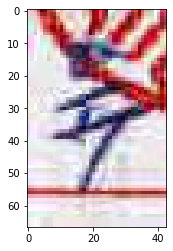

Image 5
Predict: 璟, Label: 主, Time elapsed: 0.044318199157714844



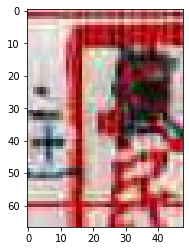

Inference Time: 0.18668265342712403


In [23]:
import matplotlib.image as mpimg

fig = plt.figure()

since = time.time()

words = ['2530_田.jpg', '22972_千.jpg', '35749_田.jpg', '38828_昇.jpg', '57332_主.jpg']

for i, word in enumerate(words):
    start = time.time()
    pred, label = inference_model(model_ft, os.path.join('./data/all/', word))
    print(f'Image {i + 1}\nPredict: {pred}, Label: {label}, Time elapsed: {time.time() - start}\n')
    img = mpimg.imread(os.path.join('./data/all', word))
    plt.imshow(img)
    plt.pause(0.001)
    
time_elapsed = time.time() - since

print(f'Inference Time: {time_elapsed / len(words)}')

In [15]:
torch.save(model_ft.state_dict(), './models/efficientnet-b7.pth')